In [3]:
!pip install tf-nightly

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0-dev20210602


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
def trend(time, slope=0):
    return slope*time

In [7]:
def seasonal_pattern(season_time):
    return np.where(
        season_time < 0.4,
        np.cos(season_time*2*np.pi),
        1/np.exp(3*season_time)
    )

In [8]:
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time+phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [9]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [10]:
time = np.arange(4*365+1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [11]:
series = baseline + trend(time, slope) + seasonality(
    time, period = 365, amplitude = amplitude
)

In [12]:
series += noise(time, noise_level, seed = 42)

In [13]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [14]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [17]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(
    x_train,
    window_size, batch_size,
    shuffle_buffer_size
)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis=-1),
        input_shape = [None]
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences = True)
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32)
    ),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(
        lambda x: x * 100.0
    )
])

In [19]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

In [21]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate = 1e-8,
    momentum = 0.9
)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

In [23]:
history = model.fit(dataset, epochs = 100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 14ms/step - loss: 21.5167 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 21.1522 - mae: 21.6444
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 20.7302 - mae: 21.2236
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 20.2834 - mae: 20.7757
Epoch 5/100
31/31 [==============================] - 1s 14ms/step - loss: 19.7897 - mae: 20.2855
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 19.1782 - mae: 19.6696
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 18.2410 - mae: 18.7333
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 17.4825 - mae: 17.9748
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 17.1597 - mae: 17.6529
Epoch 10/100
31/31 [==============================] - 0s 14ms/step - loss: 16.8547 - mae: 17.3463
Epoch 11/100
31/31 [=========

31/31 [==============================] - 0s 14ms/step - loss: 8.6159 - mae: 9.1073
Epoch 86/100
31/31 [==============================] - 0s 14ms/step - loss: 6.2022 - mae: 6.6859
Epoch 87/100
31/31 [==============================] - 0s 14ms/step - loss: 9.0977 - mae: 9.5877
Epoch 88/100
31/31 [==============================] - 0s 14ms/step - loss: 7.4476 - mae: 7.9308
Epoch 89/100
31/31 [==============================] - 0s 14ms/step - loss: 7.5566 - mae: 8.0447
Epoch 90/100
31/31 [==============================] - 0s 14ms/step - loss: 6.7840 - mae: 7.2685
Epoch 91/100
31/31 [==============================] - 0s 14ms/step - loss: 7.3749 - mae: 7.8616
Epoch 92/100
31/31 [==============================] - 0s 14ms/step - loss: 9.1213 - mae: 9.6095
Epoch 93/100
31/31 [==============================] - 0s 14ms/step - loss: 7.5663 - mae: 8.0524
Epoch 94/100
31/31 [==============================] - 0s 14ms/step - loss: 10.1335 - mae: 10.6236
Epoch 95/100
31/31 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

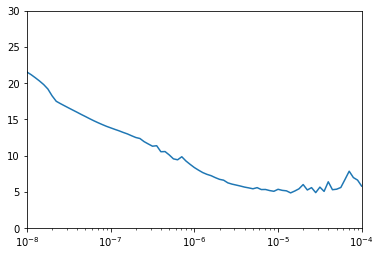

In [25]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [27]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(
    x_train,
    window_size, batch_size, 
    shuffle_buffer_size
)

In [29]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [30]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [33]:
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 14ms/step - loss: 21.5167 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 21.1522 - mae: 21.6444
Epoch 3/100
31/31 [==============================] - 1s 14ms/step - loss: 20.7302 - mae: 21.2236
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 20.2834 - mae: 20.7757
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 19.7897 - mae: 20.2855
Epoch 6/100
31/31 [==============================] - 1s 14ms/step - loss: 19.1782 - mae: 19.6696
Epoch 7/100
31/31 [==============================] - 1s 14ms/step - loss: 18.2410 - mae: 18.7333
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 17.4825 - mae: 17.9748
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 17.1597 - mae: 17.6529
Epoch 10/100
31/31 [==============================] - 0s 14ms/step - loss: 16.8547 - mae: 17.3463
Epoch 11/100
31/31 [=========

31/31 [==============================] - 0s 14ms/step - loss: 8.6159 - mae: 9.1073
Epoch 86/100
31/31 [==============================] - 0s 14ms/step - loss: 6.2022 - mae: 6.6859
Epoch 87/100
31/31 [==============================] - 0s 14ms/step - loss: 9.0977 - mae: 9.5877
Epoch 88/100
31/31 [==============================] - 0s 14ms/step - loss: 7.4476 - mae: 7.9308
Epoch 89/100
31/31 [==============================] - 0s 14ms/step - loss: 7.5566 - mae: 8.0447
Epoch 90/100
31/31 [==============================] - 0s 14ms/step - loss: 6.7840 - mae: 7.2685
Epoch 91/100
31/31 [==============================] - 0s 14ms/step - loss: 7.3749 - mae: 7.8616
Epoch 92/100
31/31 [==============================] - 0s 14ms/step - loss: 9.1213 - mae: 9.6095
Epoch 93/100
31/31 [==============================] - 0s 14ms/step - loss: 7.5663 - mae: 8.0524
Epoch 94/100
31/31 [==============================] - 0s 14ms/step - loss: 10.1335 - mae: 10.6236
Epoch 95/100
31/31 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

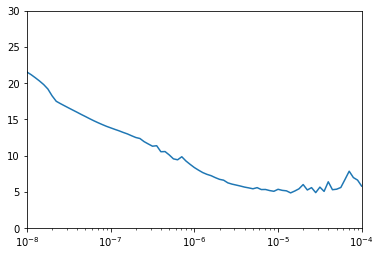

In [34]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

In [36]:
dataset = windowed_dataset(
    x_train, 
    window_size, batch_size, 
    shuffle_buffer_size
)

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences = True)
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [38]:
model.compile(
    loss = "mse",
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 1e-5,
        momentum = 0.9
    ),
    metrics = ["mae"]
)

In [39]:
history = model.fit(
    dataset,
    epochs = 500,
    verbose = 1
)

Epoch 1/500
31/31 [==============================] - 4s 14ms/step - loss: 774.5022 - mae: 21.3913
Epoch 2/500
31/31 [==============================] - 0s 14ms/step - loss: 121.7307 - mae: 8.3307
Epoch 3/500
31/31 [==============================] - 0s 14ms/step - loss: 135.0704 - mae: 8.9501
Epoch 4/500
31/31 [==============================] - 0s 14ms/step - loss: 189.9961 - mae: 10.0566
Epoch 5/500
31/31 [==============================] - 0s 14ms/step - loss: 186.9908 - mae: 10.4574
Epoch 6/500
31/31 [==============================] - 0s 14ms/step - loss: 214.1910 - mae: 11.4668
Epoch 7/500
31/31 [==============================] - 0s 14ms/step - loss: 101.5410 - mae: 7.5242
Epoch 8/500
31/31 [==============================] - 1s 14ms/step - loss: 165.0730 - mae: 9.8852
Epoch 9/500
31/31 [==============================] - 0s 14ms/step - loss: 100.7608 - mae: 7.7020
Epoch 10/500
31/31 [==============================] - 0s 14ms/step - loss: 78.4404 - mae: 6.8503
Epoch 11/500
31/31 [======

31/31 [==============================] - 0s 14ms/step - loss: 52.7472 - mae: 5.4955
Epoch 86/500
31/31 [==============================] - 0s 14ms/step - loss: 43.7416 - mae: 4.9494
Epoch 87/500
31/31 [==============================] - 0s 14ms/step - loss: 59.0283 - mae: 5.8668
Epoch 88/500
31/31 [==============================] - 0s 14ms/step - loss: 53.5406 - mae: 5.5801
Epoch 89/500
31/31 [==============================] - 0s 14ms/step - loss: 46.6594 - mae: 5.2569
Epoch 90/500
31/31 [==============================] - 0s 14ms/step - loss: 49.2235 - mae: 5.3231
Epoch 91/500
31/31 [==============================] - 0s 14ms/step - loss: 58.4289 - mae: 5.9693
Epoch 92/500
31/31 [==============================] - 0s 14ms/step - loss: 48.0703 - mae: 5.2813
Epoch 93/500
31/31 [==============================] - 0s 14ms/step - loss: 46.4464 - mae: 5.1500
Epoch 94/500
31/31 [==============================] - 0s 14ms/step - loss: 48.9822 - mae: 5.2693
Epoch 95/500
31/31 [=======================

31/31 [==============================] - 0s 14ms/step - loss: 42.0708 - mae: 4.9663
Epoch 169/500
31/31 [==============================] - 0s 14ms/step - loss: 52.6188 - mae: 5.5735
Epoch 170/500
31/31 [==============================] - 0s 14ms/step - loss: 45.7349 - mae: 5.1851
Epoch 171/500
31/31 [==============================] - 0s 14ms/step - loss: 40.4809 - mae: 4.7958
Epoch 172/500
31/31 [==============================] - 0s 14ms/step - loss: 47.4151 - mae: 5.1924
Epoch 173/500
31/31 [==============================] - 0s 14ms/step - loss: 42.0744 - mae: 4.9098
Epoch 174/500
31/31 [==============================] - 1s 14ms/step - loss: 49.1057 - mae: 5.3099
Epoch 175/500
31/31 [==============================] - 0s 14ms/step - loss: 40.9534 - mae: 4.8133
Epoch 176/500
31/31 [==============================] - 0s 14ms/step - loss: 41.6942 - mae: 4.9074
Epoch 177/500
31/31 [==============================] - 0s 14ms/step - loss: 42.5054 - mae: 4.9332
Epoch 178/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 38.6848 - mae: 4.6972
Epoch 252/500
31/31 [==============================] - 0s 14ms/step - loss: 47.5727 - mae: 5.3184
Epoch 253/500
31/31 [==============================] - 0s 14ms/step - loss: 40.9715 - mae: 4.8091
Epoch 254/500
31/31 [==============================] - 0s 14ms/step - loss: 40.6225 - mae: 4.8182
Epoch 255/500
31/31 [==============================] - 0s 14ms/step - loss: 50.9718 - mae: 5.4800
Epoch 256/500
31/31 [==============================] - 0s 14ms/step - loss: 42.5306 - mae: 4.9381
Epoch 257/500
31/31 [==============================] - 0s 14ms/step - loss: 49.0468 - mae: 5.3797
Epoch 258/500
31/31 [==============================] - 0s 14ms/step - loss: 41.3635 - mae: 4.8864
Epoch 259/500
31/31 [==============================] - 0s 14ms/step - loss: 40.8854 - mae: 4.9003
Epoch 260/500
31/31 [==============================] - 0s 14ms/step - loss: 49.7599 - mae: 5.3775
Epoch 261/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 37.8628 - mae: 4.6303
Epoch 335/500
31/31 [==============================] - 0s 14ms/step - loss: 41.1316 - mae: 4.9375
Epoch 336/500
31/31 [==============================] - 0s 14ms/step - loss: 43.3391 - mae: 5.0400
Epoch 337/500
31/31 [==============================] - 0s 14ms/step - loss: 41.5092 - mae: 4.9569
Epoch 338/500
31/31 [==============================] - 0s 14ms/step - loss: 42.6505 - mae: 4.9788
Epoch 339/500
31/31 [==============================] - 0s 14ms/step - loss: 40.7095 - mae: 4.8355
Epoch 340/500
31/31 [==============================] - 0s 14ms/step - loss: 41.2598 - mae: 4.9144
Epoch 341/500
31/31 [==============================] - 0s 14ms/step - loss: 41.6330 - mae: 4.9110
Epoch 342/500
31/31 [==============================] - 1s 14ms/step - loss: 50.9604 - mae: 5.5304
Epoch 343/500
31/31 [==============================] - 0s 14ms/step - loss: 47.0058 - mae: 5.2226
Epoch 344/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 38.2838 - mae: 4.6587
Epoch 418/500
31/31 [==============================] - 0s 14ms/step - loss: 38.0272 - mae: 4.6616
Epoch 419/500
31/31 [==============================] - 0s 14ms/step - loss: 38.7193 - mae: 4.6981
Epoch 420/500
31/31 [==============================] - 0s 14ms/step - loss: 38.9117 - mae: 4.7342
Epoch 421/500
31/31 [==============================] - 0s 14ms/step - loss: 43.9165 - mae: 5.0797
Epoch 422/500
31/31 [==============================] - 0s 14ms/step - loss: 44.2542 - mae: 5.0756
Epoch 423/500
31/31 [==============================] - 0s 14ms/step - loss: 36.2394 - mae: 4.5670
Epoch 424/500
31/31 [==============================] - 0s 14ms/step - loss: 36.2021 - mae: 4.5490
Epoch 425/500
31/31 [==============================] - 0s 14ms/step - loss: 38.1033 - mae: 4.6680
Epoch 426/500
31/31 [==============================] - 0s 14ms/step - loss: 40.5041 - mae: 4.8737
Epoch 427/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 35.4481 - mae: 4.5215


In [40]:
forecast = []
results = []

for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis])
    )

In [41]:
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

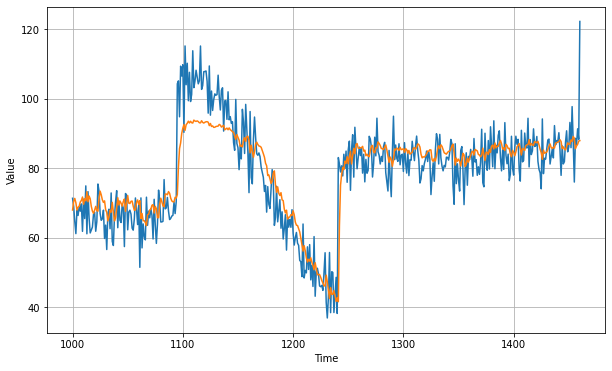

In [42]:
plt.figure(
    figsize = (10,6)
)

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.683203

In [44]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [45]:
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

<Figure size 432x288 with 0 Axes>

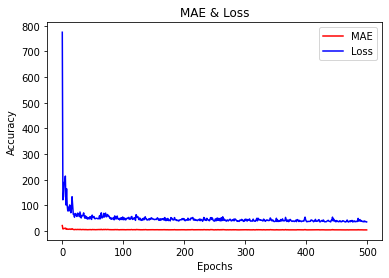

<Figure size 432x288 with 0 Axes>

In [46]:
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')

plt.title('MAE & Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [47]:
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

<Figure size 432x288 with 0 Axes>

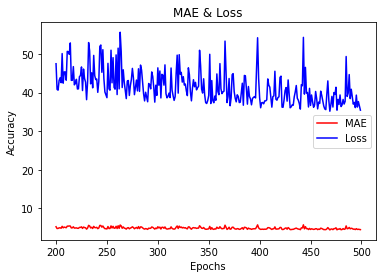

<Figure size 432x288 with 0 Axes>

In [49]:
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')

plt.title('MAE & Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [50]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(
    x_train,
    window_size, batch_size,
    shuffle_buffer_size
)

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis=-1),
        input_shape = [None]
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences = True)
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [53]:
model.compile(
    loss = "mse",
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 1e-6,
        momentum = 0.9
    )
)

In [54]:
model.fit(
    dataset,
    epochs = 100,
    verbose = 1
)

Epoch 1/100
31/31 [==============================] - 4s 14ms/step - loss: 739.1971
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 108.6536
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 74.2263
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 66.8335
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 63.2463
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 60.6564
Epoch 7/100
31/31 [==============================] - 1s 14ms/step - loss: 57.7060
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 60.1065
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 50.8930
Epoch 10/100
31/31 [==============================] - 0s 14ms/step - loss: 50.2056
Epoch 11/100
31/31 [==============================] - 0s 14ms/step - loss: 51.2970
Epoch 12/100
31/31 [==============================] - 0s 14ms/step - loss: 53.6144
Epoch 13/10

31/31 [==============================] - 0s 14ms/step - loss: 45.6529
Epoch 100/100
31/31 [==============================] - 0s 14ms/step - loss: 55.1726


In [55]:
tf.keras.backend.clear_session()

In [56]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [57]:
model.compile(
    loss = "mse", 
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 1e-6, 
        momentum = 0.9)
)

In [ ]:
model.fit(
    dataset,
    epochs = 100,
    verbose = 1
)

Epoch 1/100
31/31 [==============================] - 1s 21ms/step - loss: 48.5385
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 53.9085
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 49.4076
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 46.9661
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 49.1194
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 45.3436
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 48.8154
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 49.0880
Epoch 9/100
31/31 [==============================] - 1s 21ms/step - loss: 46.3090
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 47.4888
Epoch 11/100
31/31 [==============================] - 1s 20ms/step - loss: 53.5802
Epoch 12/100
31/31 [==============================] - 1s 21ms/step - loss: 54.9954
Epoch 13/100
